In [18]:
import pickle
import numpy as np

from plot4d.plotter import plot4d, plot4d_CS, Frame2D
from MyDataset import MyDataset

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn_evaluation import plot


RANDSTATE = 42

In [2]:
def loadXy(data_dir):
    """
    Utility function for the specific data format.
    :param data_dir: directory to the data files
    :return: X, y
    """

    with open(data_dir, "rb") as fp:   # Unpickling
        data_list = pickle.load(fp)

    xpts, ypts, zpts, _, magpts = data_list

    # check data
    assert(len(xpts)==len(ypts) and len(xpts)==len(zpts) and len(xpts)==len(magpts))

    # Transform the data into X, y form
    n = len(xpts)
    d = 3
    X = np.array([xpts, ypts, zpts]).T
    y = np.array(magpts)
    return X, y

def load_train(exp_num, withStability, verbose=3, datafolder = "Data/"):
    datafile = "data%d.pkl"%exp_num if not withStability else "data%d(withStability).pkl"%exp_num
    datafile = datafolder + datafile

    X, y = loadXy(datafile)
    venus = MyDataset()
    venus.load_split(X, y)
    if verbose&1:
        print("run %d data loaded!"%exp_num)
        venus.print_dim()
        venus.normalize()
    
    alpha = 0.15 # best value is 0.15
    kernel = Matern(nu=0.66)
    # kernel = RBF() #

    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=alpha).fit(venus.X_train, venus.y_train)

    # check
    if verbose&2:
        print("Experiment %d  "%exp_num)
        print("With Stability:", withStability,"  ")
        print("Train score: %f  "%gpr.score(venus.X_train, venus.y_train))
        print("Test score:  %f  "%gpr.score(venus.X_valid, venus.y_valid))
    
    return venus, gpr, X, y

In [3]:
# # train a model for all data
# for exp_num in range(1,3):
#     for withStability in [True, False]:
#         load_train(exp_num, withStability, verbose=2)

In [4]:
exp_num = 1
withStability = True

venus, gpr, X, y= load_train(exp_num, withStability)
alpha = 0.15


run 1 data loaded!
X_train has shape: (271, 3)
y_train has shape: (271,)
X_valid has shape: (117, 3)
y_valid has shape: (117,)
dataset normalized!
Experiment 1  
With Stability: True   
Train score: 0.969555  
Test score:  0.762494  


/home/harvey_hu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [5]:
gpr.get_params()

{'alpha': 0.15,
 'copy_X_train': True,
 'kernel__length_scale': 1.0,
 'kernel__length_scale_bounds': (1e-05, 100000.0),
 'kernel__nu': 0.66,
 'kernel': Matern(length_scale=1, nu=0.66),
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': 0}

In [6]:
param_grid = [
  {'alpha': [1e-5, 0.0001, 0.001, 0.01, 0.1], 'kernel__nu':[0.66, 0.86]},
 ]

In [7]:
gpr_ps = GaussianProcessRegressor(kernel = Matern(nu=0.66))
clf = GridSearchCV(estimator=gpr_ps,
             param_grid=param_grid)
clf.fit(X, y)

/home/harvey_hu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/harvey_hu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/harvey_hu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https:/

GridSearchCV(estimator=GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=0.66)),
             param_grid=[{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                          'kernel__nu': [0.66, 0.86]}])

<AxesSubplot:title={'center':'Grid search results'}, xlabel='alpha', ylabel='Mean score'>

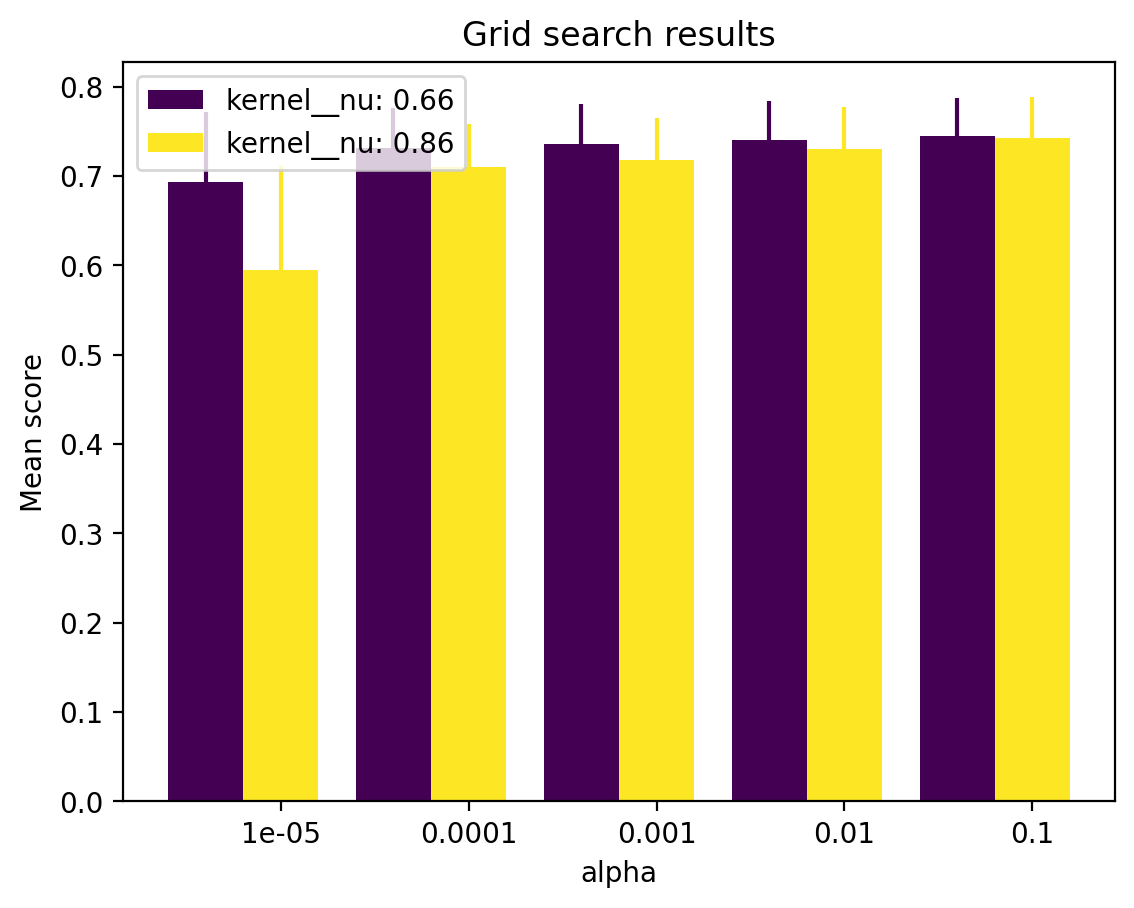

In [8]:
plot.grid_search(clf.cv_results_, change='alpha', kind='bar')

In [9]:
# Matern nu tuning
# cv_score = []
# nus = np.linspace(0.4, 2.6, 3)
# relu = lambda x: x if x>0 else 0
# for nu in nus:
#     kernel = Matern(nu=nu)
#     gpr = GaussianProcessRegressor(kernel=kernel,random_state=0, alpha=alpha).fit(venus.X_train, venus.y_train)
#     cvs = cross_val_score(gpr, X, y)
#     avg_cvs = sum(cvs)/len(cvs)
#     print("%f for nu=%f"%(avg_cvs, nu))
#     cv_score.append(avg_cvs)

# cv_score = [relu(x) for x in cv_score]
# plt.plot(nus, cv_score, label="Cross-Validation Score")
# plt.legend()
# plt.xlabel("nu")
# plt.title("Matern Kernel (alpha = 0.15)")
# plt.savefig("Matern nu.png")

In [10]:
# use all available data for the final model
kernel = Matern(nu=0.66)

venus_whole = MyDataset()
venus_whole.load_split(X, y, test_ratio=0)
venus_whole.populate(X, None, y, None)
venus_whole.normalize()

gpr = GaussianProcessRegressor(kernel=kernel,random_state=1, alpha=alpha).fit(venus_whole.X_train, venus_whole.y_train)
print("Whole dataset training score: %f"%gpr.score(venus_whole.X_train, venus_whole.y_train))

dataset normalized!
Whole dataset training score: 0.972227


In [11]:
# save the model and print the normalizing lists used
with open("Models/gprMatern0.66.dump" , "wb") as f:
    pickle.dump(gpr, f)
print(venus_whole.avg_list, venus_whole.std_list)

[102.52640418 104.08696283 122.59401936] [3.34305675 3.45653727 3.00584971]


In [12]:
def denormalize_gpr(gpr, dataset):
    """Denormalize and unpack gpr into a mean function and a variance function. """
    def gauss_mean(x, y, z):
        arr = np.array([[x,y,z]])
        arr = dataset.normalize_vec(arr)
        result = gpr.predict(arr)
        return result
    
    def gauss_var(x, y, z):
        arr = np.array([[x,y,z]])
        arr = dataset.normalize_vec(arr)
        result = gpr.predict(arr, return_std=True)[1]
        return result
    return gauss_mean, gauss_var

In [20]:
gauss_mean, gauss_var = denormalize_gpr(gpr, venus_whole)

z_values = np.linspace(117, 130, 27)
plot4d(gauss_mean, z_values, path="Graphs/test/", color_num = 21, 
       wbounds=(0, 170), frame=Frame2D(xmin=min(X[:,0]), xmax=max(X[:,0]), ymin=min(X[:,1]), 
                                       ymax=max(X[:,1]), xlabel="x", ylabel="y"))
# plot_4D(gauss_mean, z_values, "Figures/GPRplots/mean_refact/", color_num = 21, wbounds=(0, 170))
# plot_4D(gauss_var, z_values, "Figures/GPRplots/var_refact/", color_num = 21, wbounds=(0, 1))

Animation saved as "Graphs/test/Cross Sections.gif"


'Graphs/test/Cross Sections.gif'

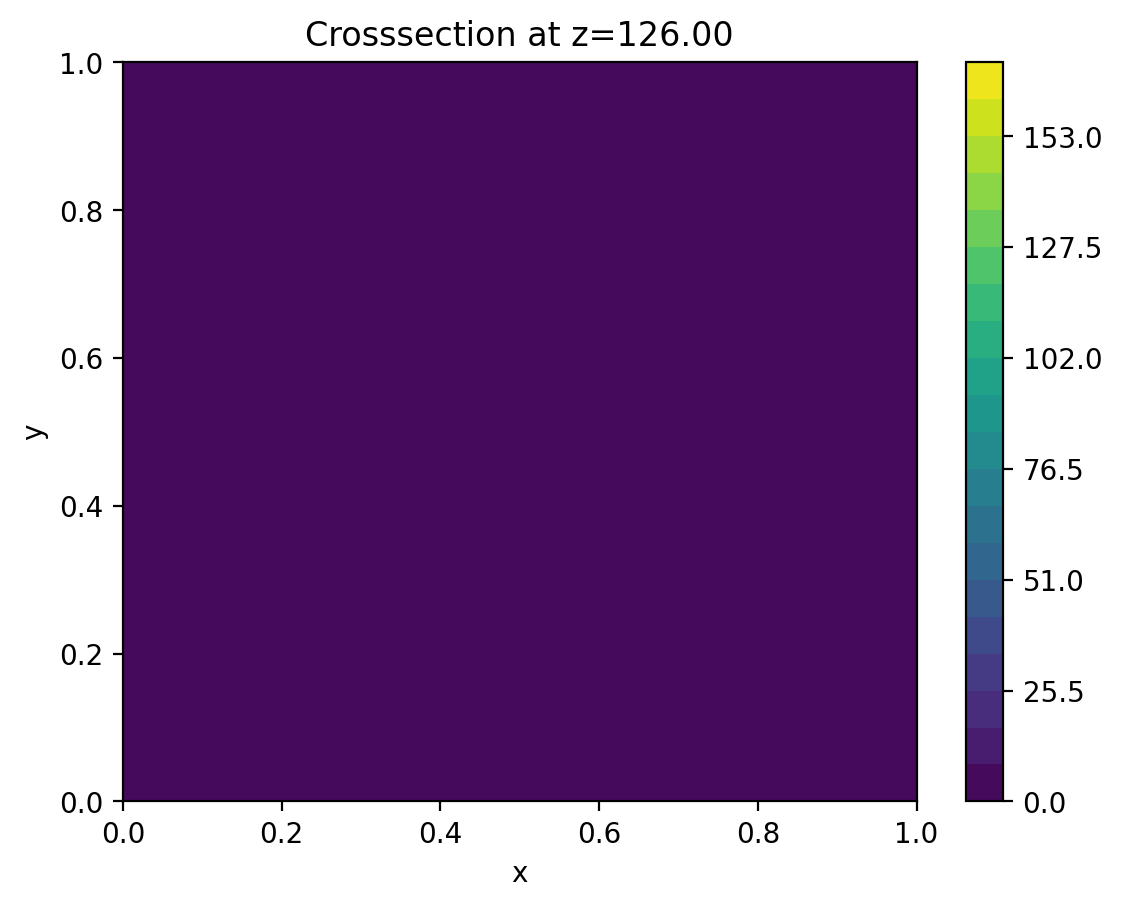

In [21]:
plot4d_CS(gauss_mean, 126, Frame2D(xmin=min(X[:,0]), xmax=max(X[:,0]), ymin=min(X[:,1]), 
                                       ymax=max(X[:,1]), wbounds=(0, 170))
# plot_4D(gauss_mean, z_values, func_name="test",save_images=False, color_num = 21, wbounds=(0, 170))

# Compare the Normalized Results of the two runs

In [ ]:
# train two models

def train_model_on_run(data_dir):
    X, y = loadXy(data_dir)
    venus_whole = MyDataset()
    venus_whole.populate(X, None, y, None)
    venus_whole.normalize()

    kernel = Matern(nu=0.66)
    gpr = GaussianProcessRegressor(kernel=kernel,random_state=1, alpha=alpha).fit(venus_whole.X_train, venus_whole.y_train)
    print("Whole dataset training score: %f"%gpr.score(venus_whole.X_train, venus_whole.y_train))
    return gpr, venus_whole

gpr1, venus1 = train_model_on_run("Data/data1.pkl")
gpr2, venus2 = train_model_on_run("Data/data2.pkl")

dataset normalized!
Whole dataset training score: 0.972426
dataset normalized!
Whole dataset training score: 0.956383


In [ ]:
# for z in np.linspace(117, 130, 27):
#     plot_cross_section(gpr1, z, dataset=venus1, plotVar=True)
#     plot_cross_section(gpr1, z, dataset=venus1, plotVar=False)

In [ ]:
filenames1 = []
filenames2 = []
for z in np.linspace(117, 130, 27):
    filenames1.append(plot_cross_section(gpr2, z, dataset=venus2, plotVar=True))
    filenames2.append(plot_cross_section(gpr2, z, dataset=venus2, plotVar=False, z_ratio=0.87)) # , 
    

with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames1:
        image = imageio.imread(filename)
        writer.append_data(image)

NameError: name 'plot_cross_section' is not defined